# ARIMA, SARIMA & SUAVIZAMIENTO EXPONENCIAL

# Suavizamiento Exponencial Triple

In [105]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import warnings
plt.style.use("seaborn-whitegrid")

warnings.filterwarnings("ignore")

In [17]:
# Lectura de los datos
import os
os.chdir("C:\\Users\\kaes1\\Documents\\Series de tiempo")
ermita = pd.read_csv("datos_imputados.csv", index_col=0)
test_data = pd.read_csv("test_data.csv", index_col=0)
ermita["fecha"]= pd.to_datetime(ermita["fecha"])
test_data["fecha"]= pd.to_datetime(test_data["fecha"])


In [4]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse]},
                          index=[str_name])
    
    return df_acc

In [5]:
def ses_optimizer(train, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test_data.pm10, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

Se evaluan distintos valores de parámetros para el modelo de Suavizamiento Exponencial triple, con el fin de encontrar los mejores:

In [ ]:
import numpy as np
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ... (rest of the code for importing data and preparing test set)

best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))

for comb in abg:
    try:
        tes_model = ExponentialSmoothing(ermita.pm10_arima, trend="add", seasonal="add", seasonal_periods=24).\
                    fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(tau_test)
        mae = mean_absolute_error(test_data.pm10, y_pred)

        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        else:
            print(f"Error encountered with combination: {comb}")
    except Exception as e:
        # Manejo de errores genérico (opcional)
        print(f"Error encountered with combination: {comb}. Exception: {e}")

# ... (rest of the code for printing best parameters and evaluating model)


De este proceso, los mejores parámetros obtenidos son:

In [19]:
best_alpha, best_beta, best_gamma, best_mae = (0.30000000000000004, 0.1, 0.6, 19.16077209125565)
print(f"best alpha: {best_alpha}")
print(f"best beta: {best_beta}")
print(f"best_gamma: {best_gamma}")
print(f"best_mae: {best_mae}")

best alpha: 0.30000000000000004
best beta: 0.1
best_gamma: 0.6
best_mae: 19.16077209125565


## ENTRENAR MODELO


El horizonte de predicción será de 24 horas.

In [8]:
tau_test=24 # horizonte de predicción

In [9]:
tes_model_best = ExponentialSmoothing(ermita.pm10_arima, trend="add", seasonal="add", seasonal_periods=24).\
                    fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
                    
y_pred_t = tes_model_best.forecast(tau_test)

In [50]:
tes_pred=np.append([0,0], tes_model_best.fittedvalues.tolist())
n_first = tes_pred.shape[0] - ermita.shape[0]
ermita['TES']=tes_pred[n_first:]

Al observar el grafico de la serie ajustada, se logra apreciar a simple vista que el modelo no tiene un buen ajuste con respecto a la serie original, tomando valores negativos en algunos puntos, los cuales no son adecuados al comportamiento normal del *pm10*, que solo toma valores positivos.

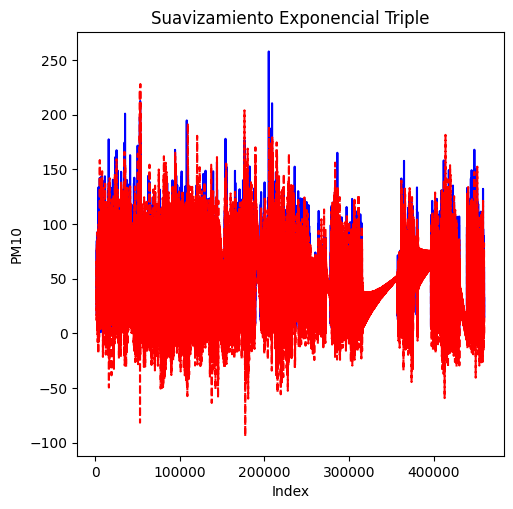

In [51]:
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)
ermita['pm10_arima'].iloc[200:].plot(color='b', linestyle = '-', ax=axarr)
ermita['TES'].iloc[200:].plot(color='r', linestyle = '--', ax=axarr)
axarr.set_title('Suavizamiento Exponencial Triple')
plt.xlabel('Index')
plt.ylabel('PM10');

El siguiente grafico muestra los resultados obtenidos al entrenar el modelo de Suavizamiento Exponencial Triple. La predicción dista de los resultados reales para el conjunto de prueba, con una diferencia abismal en las primeras horas predichas. 

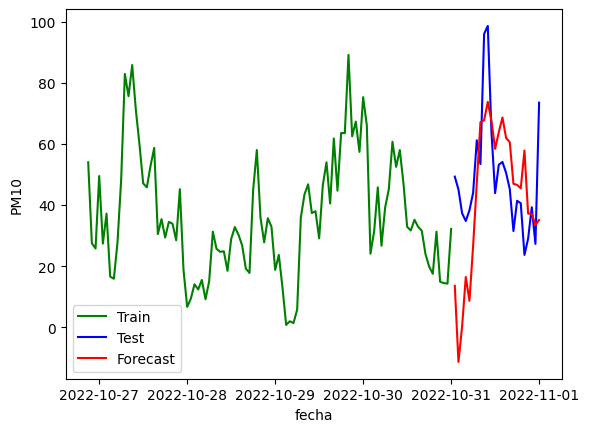

In [82]:
ax = sns.lineplot(x=ermita.fecha[-100:], y=ermita.pm10_arima[-100:], label="Train", color='g')
sns.lineplot(x=test_data.fecha, y=test_data.pm10, label="Test", color='b')
sns.lineplot(x=test_data.fecha, y=np.array(y_pred_t), label="Forecast", color='r')
plt.ylabel('PM10');
plt.show()

## EVALUAR MODELO

Las metricas de evaluación obtenidas para este modelo se muestran a continuación: 

In [20]:
test_24dl = test_data.pm10.tolist()
set_metrics=forecast_accuracy(np.array(test_24dl), np.array(y_pred_t), "24 days")
set_metrics

,MAE,MSE,MAPE,RMSE
24 days,19.160944,545.204776,4.861918,23.34962


El valor del *MAPE* indica que la predicción esta mas de un 400% desviada de los valores reales de *pm10*, por lo que la predicción obtenida con este modelo no es muy buena. 

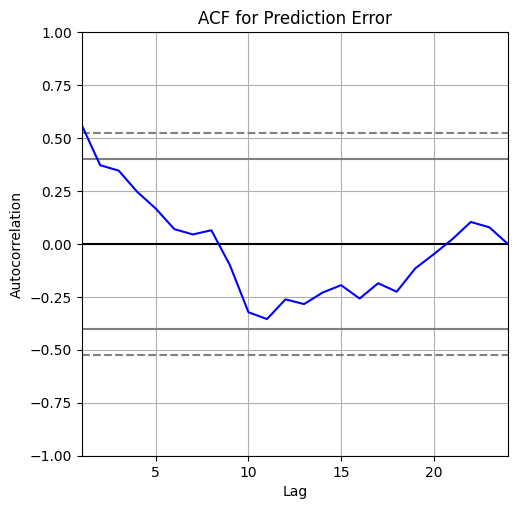

In [23]:
pred_error = np.array(test_24dl) - np.array(y_pred_t)
fig = plt.figure(figsize=(5.5, 5.5))
autocorrelation_plot(pred_error, color='b')
plt.title('ACF for Prediction Error');

El grafico de ACF indica que no existe autocorrelación significativa entre los errores de predicción. 

En cuanto a los residuos, se evalua si estos cumplen los supuestos de normalidad, homocedasticidad e independencia. 

En el grafico de Autocorrelación se logra apreciar que la autocorrelación de los residuos es estadisticamente significativa, y además tiene un patrón marcado, lo que indica que todavia existe información sobre el componente estacional que no ha sido captada por el modelo.

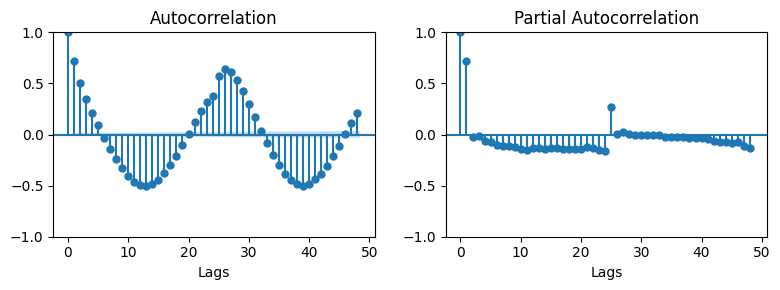

In [69]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_acf(tes_model_best.resid, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(tes_model_best.resid, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

Lo anterior se reafirma al realiza la prueba de Ljung–Box , con un nivel de significancia de 0.05. Se rechaza la hipotesis nula para la prueba, lo que indica que la autocorrelación existente entre los residuos es distinta de cero.

In [33]:
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(tes_model_best.resid,
                                                                 nlags=24,
                                                                 qstat=True,
                                                                 alpha=0.05)

alpha = 0.05
for l, p_val in enumerate(pvalues_djia):
    if p_val > alpha:
        print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
    else:
        print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))

Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
Null hypothesis is rejected at lag = 10 for p-val = 0.0
Null hypothesis is rejected at lag = 11 for p-val = 0.0
Null hypothesis is rejected at lag = 12 for p-val = 0.0
Null hypothesis is rejected at lag = 13 for p-val = 0.0
Null hypothesis is rejected at lag = 14 for p-val = 0.0
Null hypothesis is rejected at lag = 15 for p-val = 0.0
Null hypothesis is rejected at lag = 16 for p-val = 0.0
Null hypothesis is rejected at lag = 17 for p-val = 0.0
Nu

Se analiza el grafico de normalidad y de densidad, y se realiza la prueba de Shapiro-Wilk para evlaur la normalidad de los residuos.

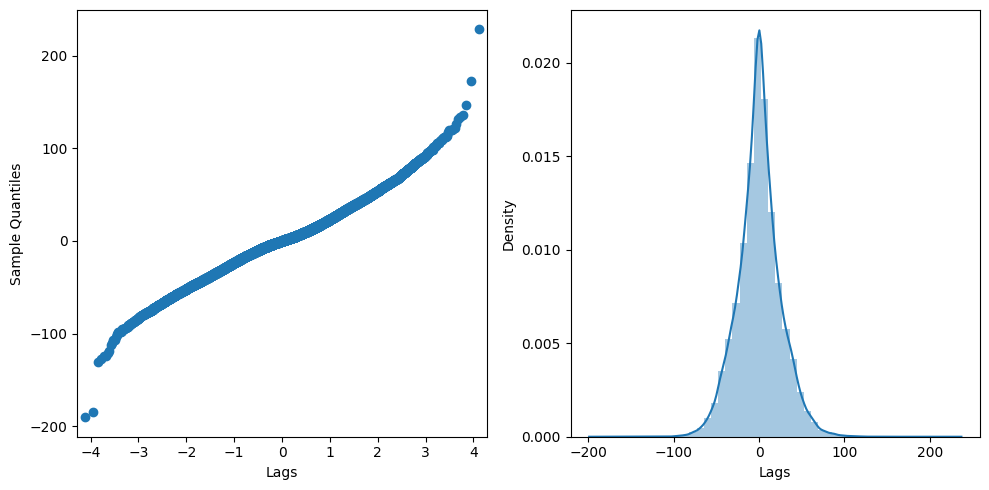

In [72]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import numpy
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(1,2,figsize=(10,5))
qqplot(tes_model_best.resid, ax=ax[0])
ax[0].set_xlabel('Lags')
sns.distplot(a=tes_model_best.resid, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

In [73]:

from scipy.stats import shapiro

# conduct the Shapiro-Wilk Test
shapiro(tes_model_best.resid)


ShapiroResult(statistic=0.9898489117622375, pvalue=0.0)

Se obtiene que los residuos no cumplen el supuesto de normalidad, bajo un nivel de significancia de 0.05, al rechazar la hipotesis nula de la prueba (los residuos provienen de una distribución normal)

# ARIMA

In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa

In [334]:
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = smtsa.ARIMA(ermita.pm10_arima.tolist(), order=(ari, d, maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass

Se busca el mejor modelo ARIMA optimizando la metrica AIC.

El mejor modelo ARIMA es de orden: 

In [335]:
dfAIC = pd.DataFrame(aicVal, columns=['AR(p)', 'd', 'MA(q)', 'AIC'])
print('Best ARIMA parameters based on AIC:\n')
dfAIC[dfAIC.AIC == dfAIC.AIC.min()]

Best ARIMA parameters based on AIC:



,AR(p),d,MA(q),AIC
8,2,1,2,405635.829024


## ENTRENAR MODELO

In [86]:
arima_obj = smtsa.ARIMA(ermita.pm10_arima.tolist(), order=(2, 1, 2))
arima_obj_fit = arima_obj.fit()
arima_obj_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                51096
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -202812.913
Date:                Mon, 10 Jun 2024   AIC                         405635.827
Time:                        13:10:10   BIC                         405680.034
Sample:                             0   HQIC                        405649.660
                              - 51096                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3622      0.024     57.714      0.000       1.316       1.408
ar.L2         -0.4955      0.018    -27.992      0.000      -0.530      -0.461
ma.L1         -1.5274      0.025    -62.274      0.000      -1.575      -1.479
ma.L2          0.5358      0.024     22.136      0.000       0.488       0.583
sigma2       164.1579      0.479    342.882      0.000     163.220     165.096
===================================================================================
Ljung-Box (L1) (Q):                   1.81   Jarque-Bera (JB):            132434.35
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Del resumen anterior se obtiene, para un nivel de significancia de 0.05:
* Los coeficientes son significativos (p-valor < 0.05) 
* Los residuos son independientes (Ljung-Box p-valor > 0.05) 
* Los residuos no presentan heteroscedasticidad (Heteroskedasticity (H) p-valor > 0.05) 
* Se rechaza la hipotesis de normalidad, por lo cual los residuos no tienen distribución normal (Jarque-Bera p-valor <0.05)

In [87]:
arima_pred=np.append([0,0], arima_obj_fit.fittedvalues.tolist())
n_first = arima_pred.shape[0] - ermita.shape[0]
ermita['ARIMA']=arima_pred[n_first:]
diffval=np.append([0,0], arima_obj_fit.resid)
ermita['diffval']=diffval[n_first:]

Al realizar el entrenamiento del modelo, se ajusta la serie de tiempo. La serie tiempo ajustada tiene un mejor ajuste al observado en el modelo de Suavizamiento Exponencial Triple.

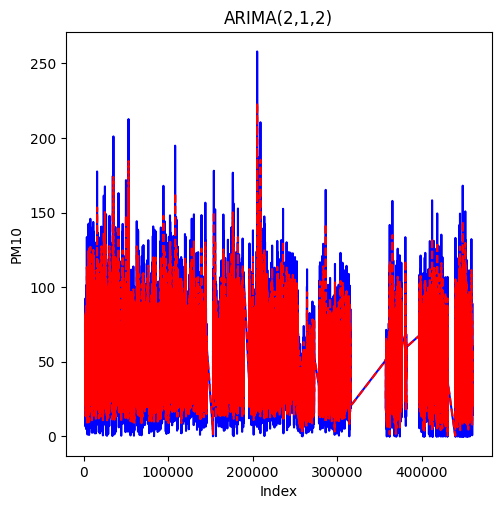

In [88]:
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)
ermita['pm10_arima'].iloc[200:].plot(color='b', linestyle = '-', ax=axarr)
ermita['ARIMA'].iloc[200:].plot(color='r', linestyle = '--', ax=axarr)
axarr.set_title('ARIMA(2,1,2)')
plt.xlabel('Index')
plt.ylabel('PM10');

Al realizar la predicción para un horizonte de 24 horas, se obtiene los valores obtenidos simulan una linea constnate que no capta la variabilidad de la serie de tiempo para el *pm10*.

In [91]:
best_order = (2,1,2)
pred_arima = arima_obj_fit.forecast(24)
test_24dl_x = test_data.pm10.tolist()

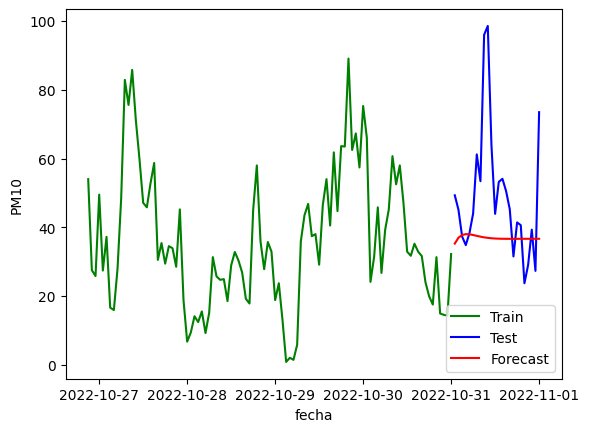

In [93]:
ax = sns.lineplot(x=ermita.fecha[-100:], y=ermita.pm10_arima[-100:], label="Train", color='g')
sns.lineplot(x=test_data.fecha, y=test_24dl, label="Test", color='b')
sns.lineplot(x=test_data.fecha, y=pred_arima, label="Forecast", color='r')
plt.ylabel('PM10');
plt.show()

## EVALUAR MODELO

Las metricas de evaluación obtenidas para este modelo se muestran a continuación: 

In [94]:
arima_metrics=forecast_accuracy(np.array(test_24dl), np.array(pred_arima), "24 days")
arima_metrics

,MAE,MSE,MAPE,RMSE
24 days,15.289504,491.203154,0.415128,22.163103


El valor del *MAPE* indica que las predicciones obtenidas distan un 41% por arriba o por debajo de los valores observados. En cuanto a la raiz del error cuadratico medio (RMSE), se puede decir que las predicciones obtenidas se desvian alrededor de 22 µg/m3, de los valores reales.

In [46]:
pred_error = np.array(test_24dl) - np.array(pred_arima)

En cuanto a la autocorrelación en los errores de predicción, al observar el grafico de autocorrelación se detecta que correlación con el primer error, mientras que las correlaciones para los demás errores no son significativas. 

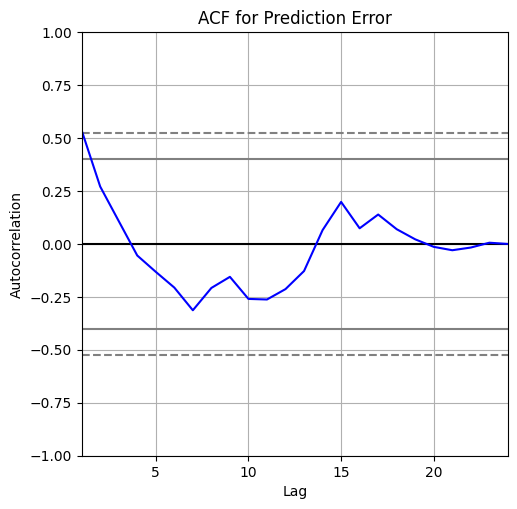

In [47]:
fig = plt.figure(figsize=(5.5, 5.5))
autocorrelation_plot(pred_error, color='b')
plt.title('ACF for Prediction Error');pred_error = np.array(test_24dl) - np.array(pred_arima)

Al analizar los residuos se confirma que el supuesto de normalidad no se cumple para, debido a que la distribución mostrada por los residuos no se asemeja a la normal, y el grafico QQ-plot muestra desviaciones en los extremos. En cuanto a la autocorrelación, solo se acepta la hipotesis nula de la prueba Ljung-Box para el primer residuo, lo que indica que es el unico que se considera independiente, los demás residuos si presentan correlación. Lo anterior indica que el modelo no se ajustó adecuadamento a los datos, por lo que existe información que el modelo no logra captar aún. 

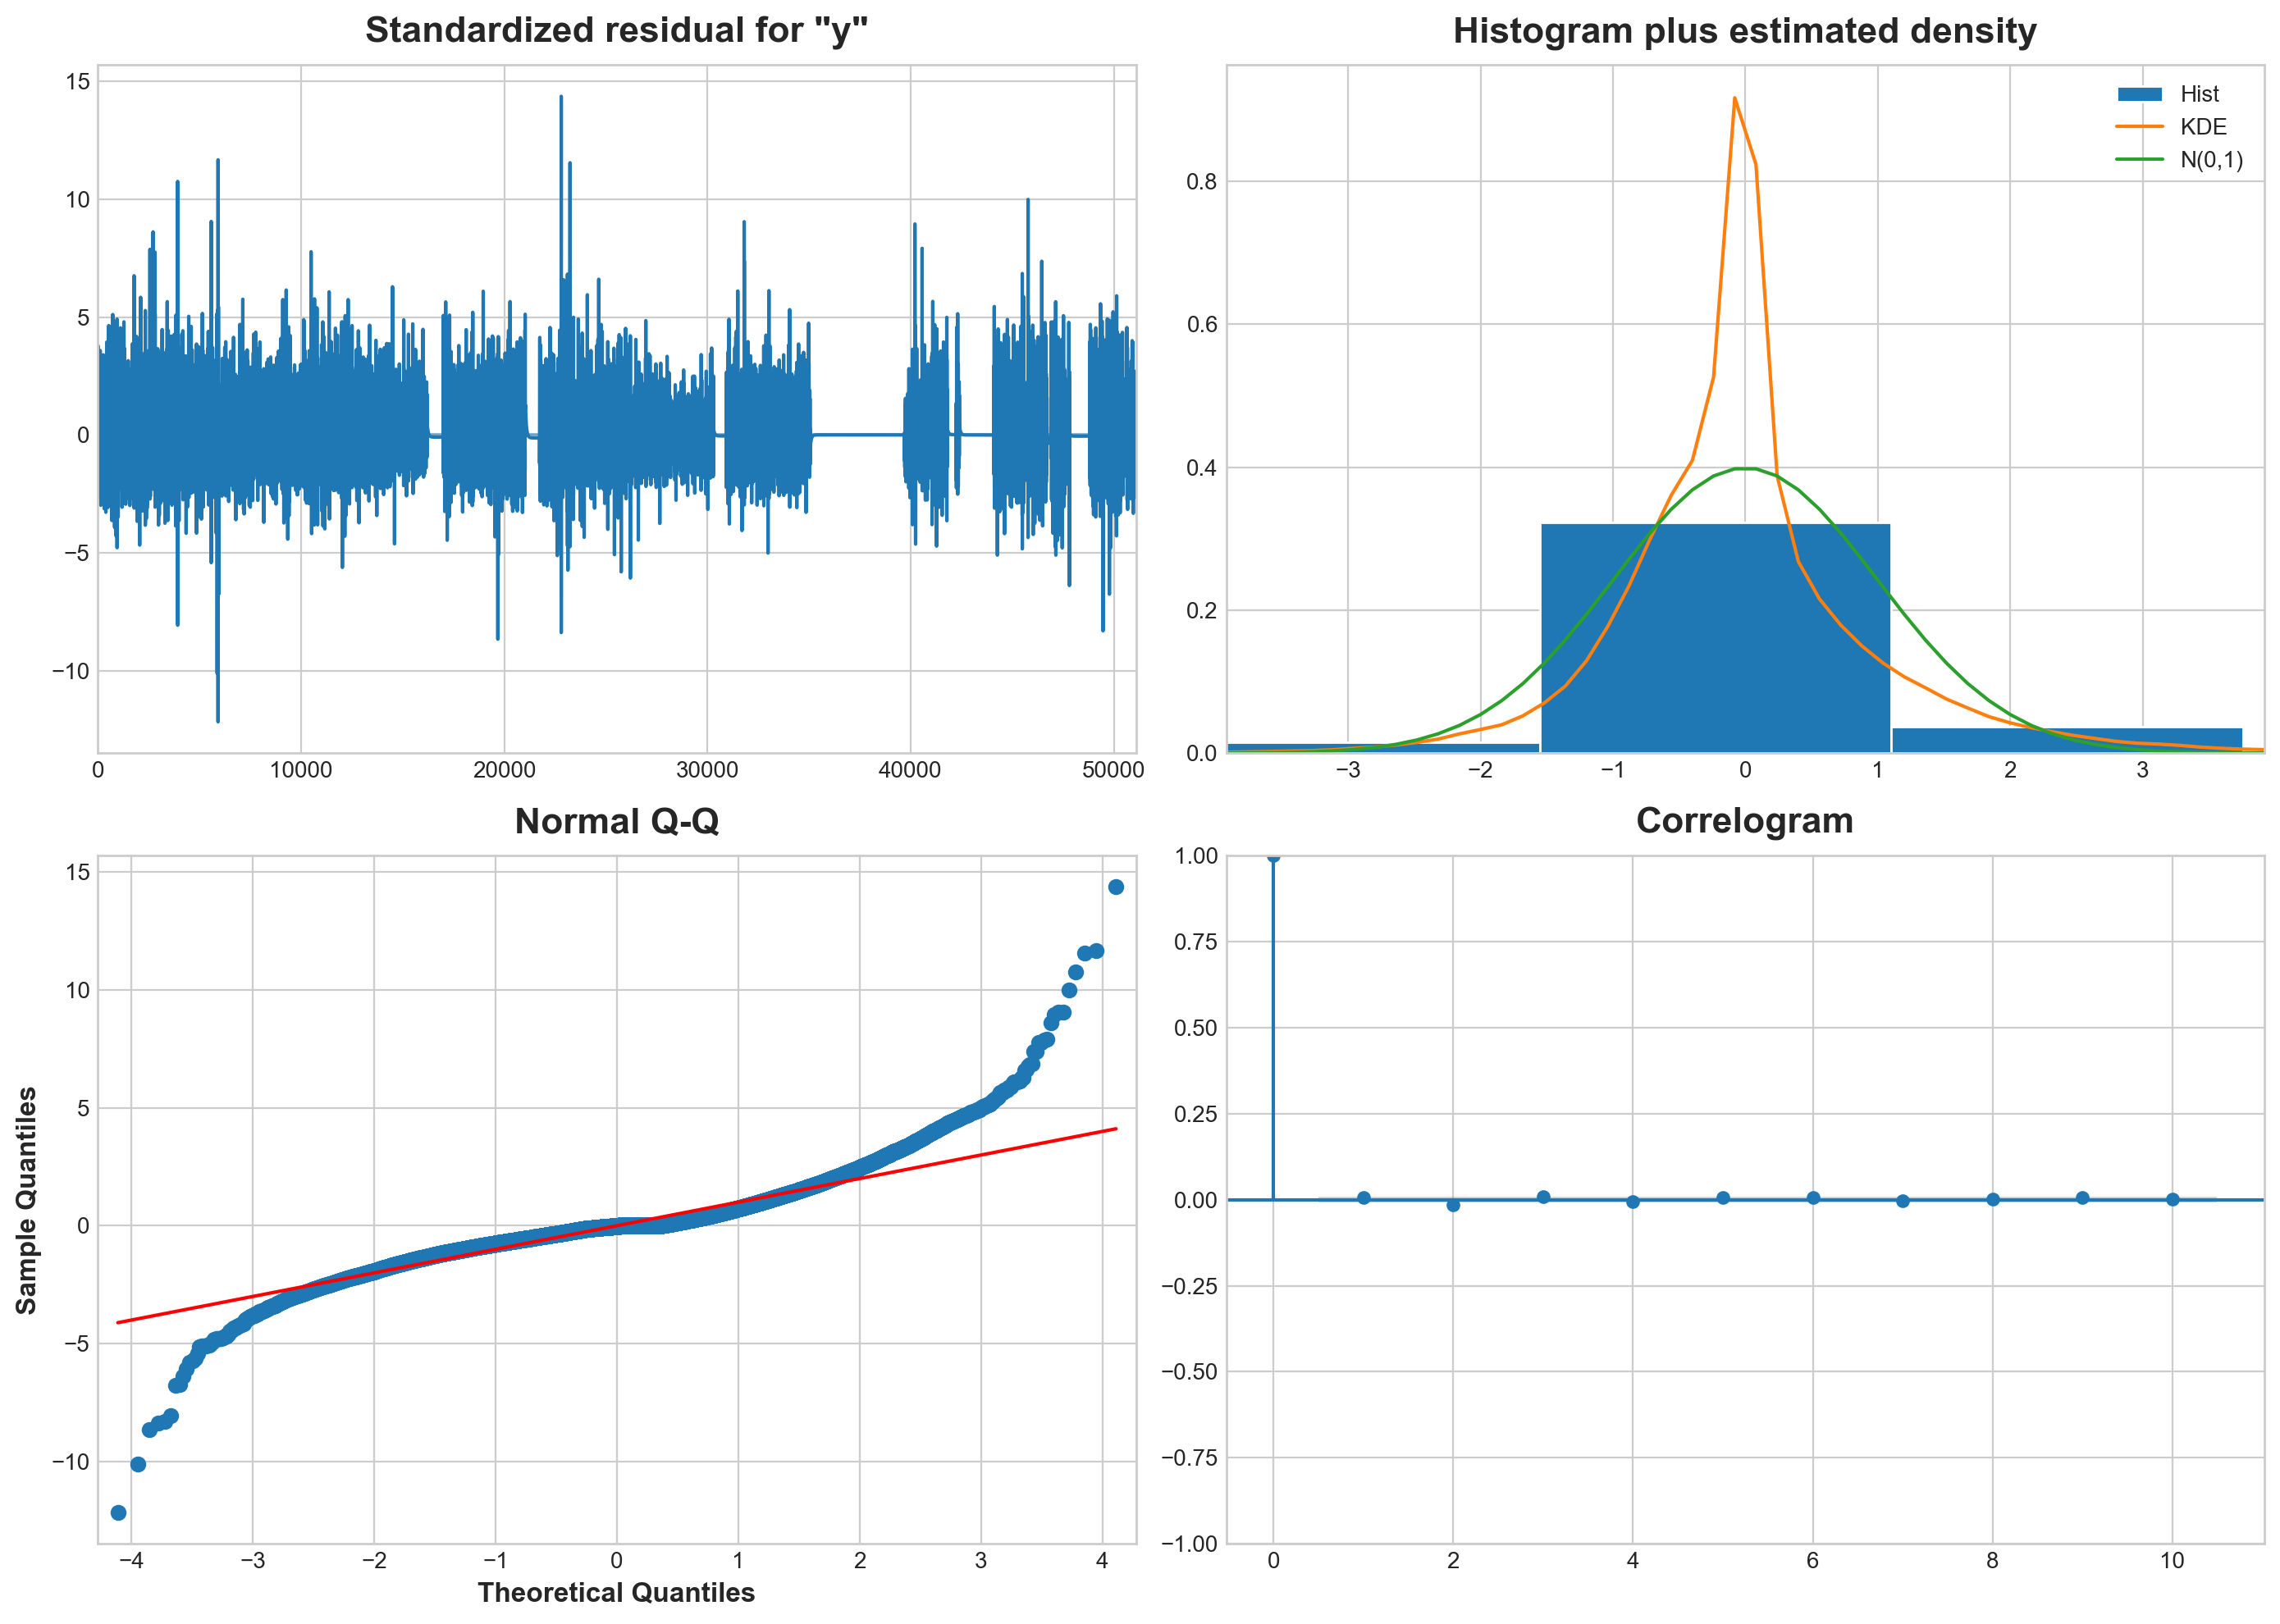

In [57]:
arima_obj_fit.plot_diagnostics(figsize=(14,10));

In [43]:
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(arima_obj_fit.resid,
                                                                 nlags=24,
                                                                 qstat=True,
                                                                 alpha=0.05)
alpha = 0.05
for l, p_val in enumerate(pvalues_djia):
    if p_val > alpha:
        print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
    else:
        print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))

Null hypothesis is accepted at lag = 0 for p-val = 0.1598976385874913
Null hypothesis is rejected at lag = 1 for p-val = 0.0006910361618951041
Null hypothesis is rejected at lag = 2 for p-val = 0.0003956932944176029
Null hypothesis is rejected at lag = 3 for p-val = 0.0007702904054350443
Null hypothesis is rejected at lag = 4 for p-val = 0.0009693240066950291
Null hypothesis is rejected at lag = 5 for p-val = 0.001216150452063847
Null hypothesis is rejected at lag = 6 for p-val = 0.001715615837267159
Null hypothesis is rejected at lag = 7 for p-val = 0.003187394392036525
Null hypothesis is rejected at lag = 8 for p-val = 0.0035964090656981688
Null hypothesis is rejected at lag = 9 for p-val = 0.005643296492691674
Null hypothesis is rejected at lag = 10 for p-val = 3.689630652559742e-05
Null hypothesis is rejected at lag = 11 for p-val = 1.3090515504061361e-07
Null hypothesis is rejected at lag = 12 for p-val = 8.038955290815212e-08
Null hypothesis is rejected at lag = 13 for p-val = 5.

# ARIMA - ROLLING

A continuación se realiza la predicción utilizando el modelo ARIMA con *Rolling*, para predecir las 24 horas siguientes con un horizonte de 1.

In [48]:
def arima_rolling(history, test):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

## ENTRENAR MODELO

In [49]:
test_24dl = test_data.pm10.tolist()
yhat_24d  = arima_rolling(ermita.pm10_arima.tolist(), test_24dl)

predicted=35.248057, expected=49.300000
predicted=48.674215, expected=45.100000
predicted=43.893417, expected=37.300000
predicted=36.916224, expected=34.800000
predicted=34.953849, expected=38.300000
predicted=38.064026, expected=44.000000
predicted=42.756608, expected=61.200000
predicted=56.814783, expected=53.400000
predicted=49.349628, expected=96.000000
predicted=84.811435, expected=98.600000
predicted=84.971216, expected=63.900000
predicted=54.907068, expected=43.900000
predicted=39.378082, expected=53.200000
predicted=48.775831, expected=54.100000
predicted=49.988127, expected=50.500000
predicted=47.218024, expected=45.200000
predicted=43.120069, expected=31.500000
predicted=32.130626, expected=41.400000
predicted=41.299369, expected=40.600000
predicted=40.623864, expected=23.700000
predicted=26.558373, expected=29.000000
predicted=31.796324, expected=39.300000
predicted=40.551807, expected=27.300000
predicted=30.107075, expected=73.500000


Al observar el grafico de las predicciones con *rolling*, se observa un mejor ajuste de las predicciones con respecto a los valores reales de *pm10*. 

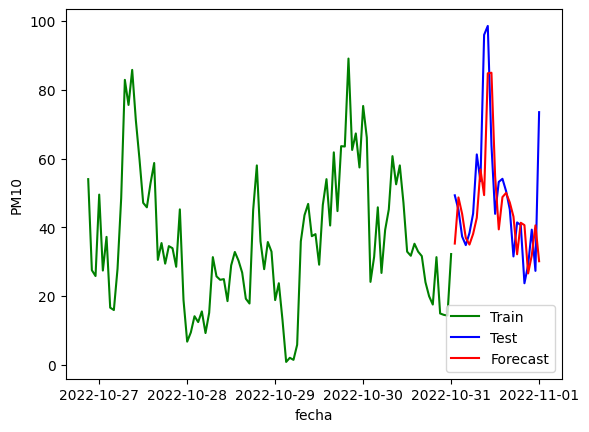

In [95]:
ax = sns.lineplot(x=ermita.fecha[-100:], y=ermita.pm10_arima[-100:], label="Train", color='g')
sns.lineplot(x=test_data.fecha, y=test_24dl, label="Test", color='b')
sns.lineplot(x=test_data.fecha, y=yhat_24d, label="Forecast", color='r')
plt.ylabel('PM10');
plt.show()

## EVALUAR MODELO

Las metricas de evaluación obtenidas para este modelo se muestran a continuación: 

In [87]:
arima_metrics=forecast_accuracy(np.array(test_24dl), np.array(yhat_24d), "24 days")
arima_metrics

,MAE,MSE,MAPE,RMSE
24 days,11.532251,268.36396,0.274156,16.381818


El valor del *MAPE* indica que las predicciones obtenidas distan un 27% por arriba o por debajo de los valores observados, siendo un valor mucho menor al obtenido con el modelo de Suavizamiento Exponencial Triple y ARIMA. En cuanto a la raiz del error cuadratico medio (RMSE), se puede decir que las predicciones obtenidas se desvian alrededor de 16 µg/m3, de los valores reales, siendo un valor menor al obtenido en el modelo ARIMA. 


En cuanto a los errores de predicción, no se observa correlación significativa en el grafico ACF, por lo que los errores son independientes. 

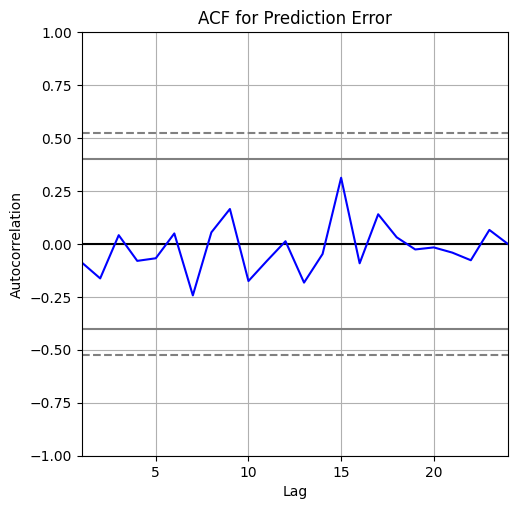

In [96]:
pred_error = np.array(test_24dl) - np.array(yhat_24d)
fig = plt.figure(figsize=(5.5, 5.5))
autocorrelation_plot(pred_error, color='b')
plt.title('ACF for Prediction Error');pred_error = np.array(test_24dl) - np.array(yhat_24d)

# SARIMA

Ahora se entrena un modelo SARIMA, es decir, un modelo ARIMA contemplando el componente estacional. En este caso se asume una estacionalidad con frecuencia 24, al ser una serie horaria. 

## ENTRENAR MODELO

Se busca el mejor modelo SARIMA optimizando el valor de AIC. Se obtiene un modelo SARIMA de orden (2, 1, 2)x(1, 1, 1)

In [100]:
x=ermita["pm10_arima"]-ermita["pm10_arima"].shift(24)
mod = sm.tsa.statespace.SARIMAX(ermita["pm10_arima"], trend='n', order=(2, 1,2),
seasonal_order=(1, 1, 1, 24))
sarimax= mod.fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           pm10_arima   No. Observations:                51096
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood             -199610.679
Date:                              Mon, 10 Jun 2024   AIC                         399235.358
Time:                                      13:42:49   BIC                         399297.245
Sample:                                           0   HQIC                        399254.724
                                            - 51096                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1592      0.082      1.947      0.052      -0.001       0.319
ar.L2          0.3790      0.059      6.395      0.000       0.263       0.495
ma.L1         -0.4124      0.081     -5.086      0.000      -0.571      -0.253
ma.L2         -0.5547      0.080     -6.969      0.000      -0.711      -0.399
ar.S.L24       0.0472      0.003     13.495      0.000       0.040       0.054
ma.S.L24      -0.9849      0.001  -1401.796      0.000      -0.986      -0.984
sigma2       145.1128      0.415    349.370      0.000     144.299     145.927
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):            138580.02
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Del resumen anterior se obtiene, para un nivel de significancia de 0.1:
* Los coeficientes son significativos (p-valor < 0.1)
* Los residuos son independientes (Ljung-Box p-valor > 0.1) 
* Los residuos no presentan heteroscedasticidad (Heteroskedasticity (H) p-valor > 0.1) 
* Se rechaza la hipotesis de normalidad, por lo cual los residuos no tienen distribución normal (Jarque-Bera p-valor <0.1)

In [101]:
sarimax_pred=np.append([0,0], sarimax.fittedvalues.tolist())
n_first = sarimax_pred.shape[0] - ermita.shape[0]
ermita['SARIMAX']=sarimax_pred[n_first:]
diffval_x=np.append([0,0], sarimax.resid)
ermita['diffval_x']=diffval_x[n_first:]

Al ajustar el modelo a la serie de tiempo del *pm10* a simple vista se logra observar que el ajuste no es muy bueno, y que la serie ajustada tiene menor magnitud que la serie original.

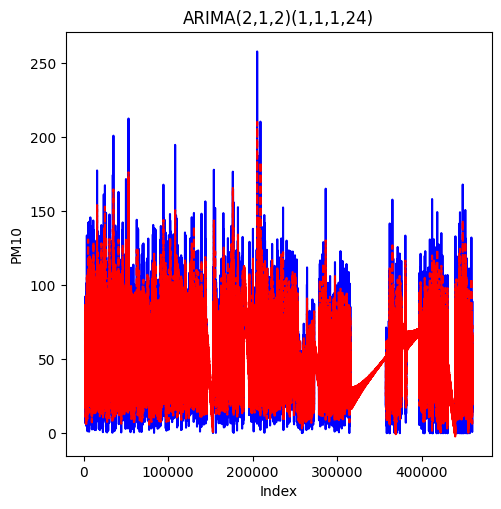

In [102]:
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)
ermita['pm10_arima'].iloc[200:].plot(color='b', linestyle = '-', ax=axarr)
ermita['SARIMAX'].iloc[200:].plot(color='r', linestyle = '--', ax=axarr)
axarr.set_title('ARIMA(2,1,2)(1,1,1,24)')
plt.xlabel('Index')
plt.ylabel('PM10');

In [103]:
pred_sarimax = sarimax.forecast(24)

La predicción obtenida, logra captar un poco mejor la variabilidad de la serie de tiempo que el modelo ARIMA sin factor estacional, aunque no logra un mejor ajuste que el modelo de ARIMA *rolling*

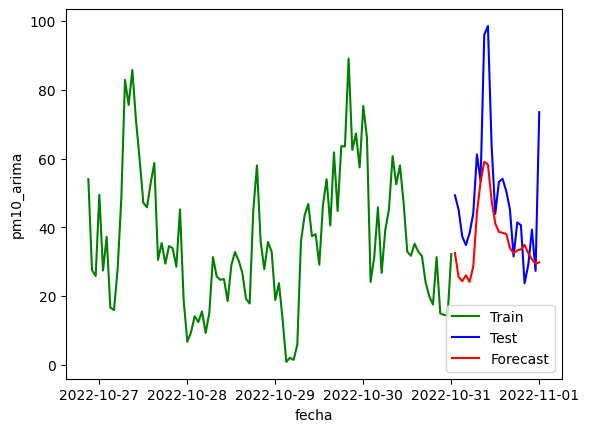

In [104]:
ax = sns.lineplot(x=ermita.fecha[-100:], y=ermita.pm10_arima[-100:], label="Train", color='g')
sns.lineplot(x=test_data.fecha, y=test_24dl_x, label="Test", color='b')
sns.lineplot(x=test_data.fecha, y=np.array(pred_sarimax) , label="Forecast", color='r')
plt.show()

## EVALUAR MODELO


Las metricas de evaluación obtenidas para este modelo se muestran a continuación: 


In [106]:
test_24dl_x = test_data.pm10.tolist()
sarimax_metrics=forecast_accuracy(np.array(test_24dl_x), np.array(pred_sarimax ), "24 days")
sarimax_metrics

,MAE,MSE,MAPE,RMSE
24 days,14.177827,328.506588,0.398828,18.124751


El valor del *MAPE* indica que las predicciones obtenidas distan un 39% por arriba o por debajo de los valores observados. En cuanto a la raiz del error cuadratico medio (RMSE), se puede decir que las predicciones obtenidas se desvian alrededor de 18 µg/m3, de los valores reales.

En cuanto a los errores de predicción, no se observa correlación significativa en el grafico ACF, por lo que los errores son independientes. 

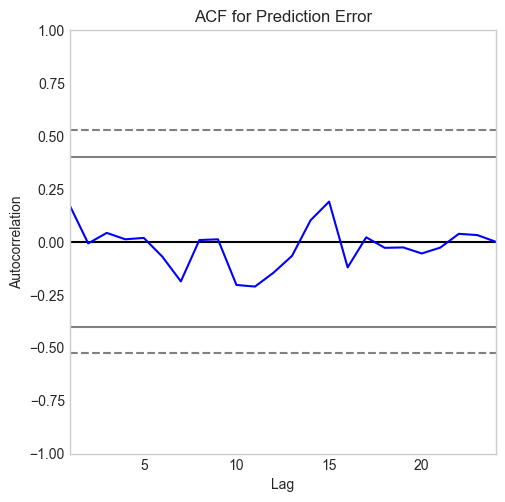

In [107]:
pred_error_x = np.array(test_24dl_x) - np.array(pred_sarimax)

fig = plt.figure(figsize=(5.5, 5.5))
autocorrelation_plot(pred_error_x, color='b')
plt.title('ACF for Prediction Error');

Al analizar los residuos se confirma que el supuesto de normalidad no se cumple para, debido a que la distribución mostrada por los residuos no se asemeja a la normal, y el grafico QQ-plot muestra desviaciones en los extremos. En cuanto a la autocorrelación, solo se acepta la hipotesis nula de la prueba Ljung-Box para los primeros 5 residuos, lo que indica que son los unicos que se consideran independientes, los demás residuos si presentan correlación. Lo anterior indica que el modelo no se ajustó adecuadamento a los datos, por lo que existe información que el modelo no logra captar aún. 

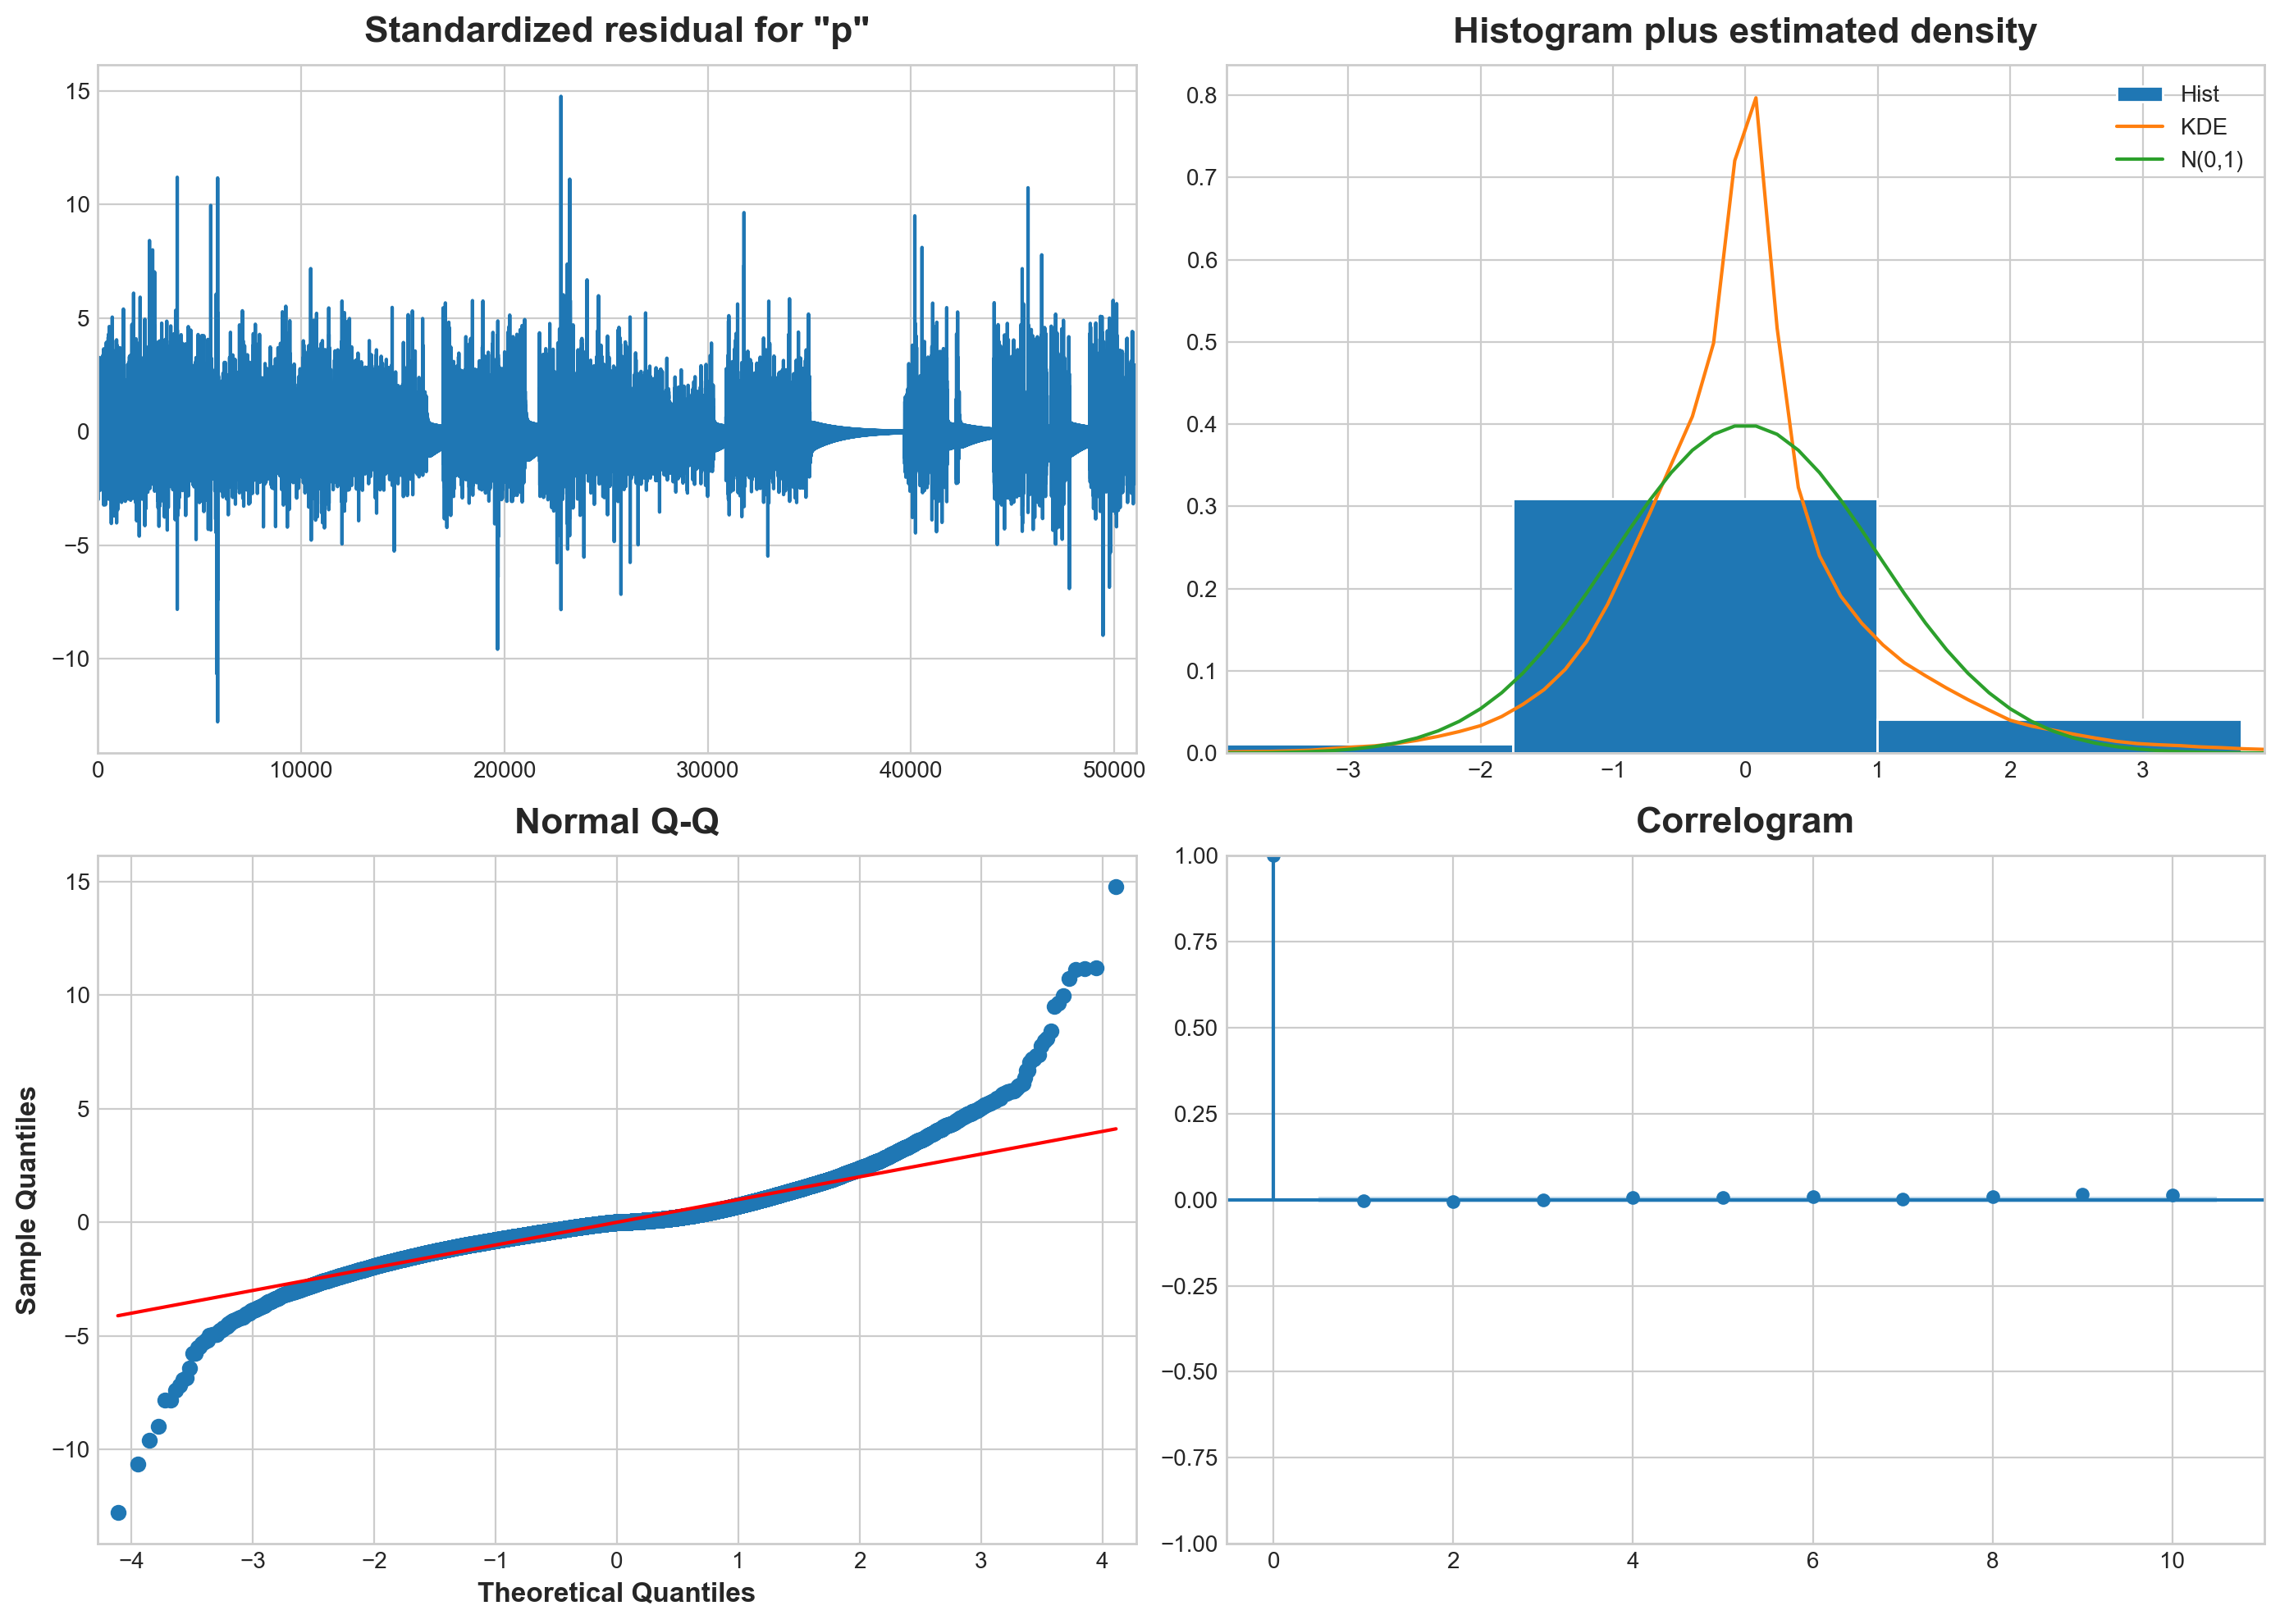

In [93]:
sarimax.plot_diagnostics(figsize=(14,10));

In [108]:
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(sarimax.resid,
                                                                 nlags=24,
                                                                 qstat=True,
                                                                 alpha=0.05)
alpha = 0.05
for l, p_val in enumerate(pvalues_djia):
    if p_val > alpha:
        print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
    else:
        print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))

Null hypothesis is accepted at lag = 0 for p-val = 0.5903222860575178
Null hypothesis is accepted at lag = 1 for p-val = 0.20050117207036366
Null hypothesis is accepted at lag = 2 for p-val = 0.35715360495527754
Null hypothesis is accepted at lag = 3 for p-val = 0.19686066004691694
Null hypothesis is accepted at lag = 4 for p-val = 0.14414885322030446
Null hypothesis is rejected at lag = 5 for p-val = 0.04978862363189598
Null hypothesis is accepted at lag = 6 for p-val = 0.07129146722542061
Null hypothesis is rejected at lag = 7 for p-val = 0.025512349215370298
Null hypothesis is rejected at lag = 8 for p-val = 0.001087795014823609
Null hypothesis is rejected at lag = 9 for p-val = 4.523615768323633e-05
Null hypothesis is rejected at lag = 10 for p-val = 3.412637636174788e-05
Null hypothesis is rejected at lag = 11 for p-val = 3.2284396517559575e-05
Null hypothesis is rejected at lag = 12 for p-val = 5.012920371101029e-05
Null hypothesis is rejected at lag = 13 for p-val = 9.4710638865